In [1]:
import pandas as pd
import numpy as np

In [2]:
final_df = pd.read_csv('final_df_ipl.csv')

In [3]:
final_df.head()

,BattingTeam,BowlingTeam,City,runs_left,balls_left,wickets,total_run_y,crr,rrr,result
0,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata,87,71,3,131,5.387755,7.352113,0
1,Delhi Daredevils,Royal Challengers Bangalore,Delhi,159,105,10,183,9.600000,9.085714,0
2,Chennai Super Kings,Mumbai Indians,Cape Town,95,62,8,165,7.241379,9.193548,0
3,Chennai Super Kings,Mumbai Indians,Mumbai,101,70,5,139,4.560000,8.657143,0
4,Delhi Daredevils,Delhi Capitals,Kolkata,106,70,9,181,9.000000,9.085714,0


In [4]:
final_df.dropna(inplace=True)

In [5]:
final_df.shape

(68160, 10)

In [17]:
final_df = final_df[final_df['balls_left'] != 0]


In [18]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [19]:
X_train

,BattingTeam,BowlingTeam,City,runs_left,balls_left,wickets,total_run_y,crr,rrr
21013,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata,108,39,6,190,6.074074,16.615385
39367,Sunrisers Hyderabad,Royal Challengers Bangalore,Bangalore,171,84,9,227,9.333333,12.214286
45479,Kolkata Knight Riders,Rajasthan Royals,Jaipur,52,17,3,164,6.524272,18.352941
3632,Mumbai Indians,Royal Challengers Bangalore,Dubai,60,24,5,165,6.562500,15.000000
41282,Royal Challengers Bangalore,Chennai Super Kings,Mumbai,112,67,6,191,8.943396,10.029851
...,...,...,...,...,...,...,...,...,...
52492,Kolkata Knight Riders,Chennai Super Kings,Ranchi,104,81,6,148,6.769231,7.703704
22022,Kolkata Knight Riders,Delhi Capitals,Delhi,115,94,9,146,7.153846,7.340426
22904,Delhi Daredevils,Delhi Capitals,Ahmedabad,83,86,8,141,10.235294,5.790698
53521,Rajasthan Royals,Sunrisers Hyderabad,Hyderabad,51,15,2,136,4.857143,20.400000


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['BattingTeam','BowlingTeam','City'])
]
,remainder='passthrough')

In [42]:
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#tried this and gives 99% acc
from sklearn.pipeline import Pipeline

In [43]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [44]:
pipe.fit(X_train,y_train)


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['BattingTeam', 'BowlingTeam',
                                                   'City'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [45]:
y_pred = pipe.predict(X_test)


In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8225770844065052

In [47]:
pipe.predict_proba(X_test)[10]


array([9.99387555e-01, 6.12444517e-04])

In [48]:
final_df.head(1)

,BattingTeam,BowlingTeam,City,runs_left,balls_left,wickets,total_run_y,crr,rrr,result
0,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata,87,71,3,131,5.387755,7.352113,0


In [49]:
def match_summary(row):
    print("Batting Team-" + row['BattingTeam'] + " | Bowling Team-" + row['BowlingTeam'] + " | Target- " + str(row['total_run_y']))
                                                                                       

In [67]:
def match_progression(x_df,ID,pipe):
    match = x_df[x_df['ID'] == ID]
    match = match[(match['ballnumber'] == 6)]
    temp_df = match[['BattingTeam','BowlingTeam','City','runs_left','balls_left','wickets','total_run_y','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_run_y'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target

In [78]:
temp_df,target = match_progression(df,980927,pipe)
temp_df

Target- 170


,end_of_over,runs_after_over,wickets_in_over,lose,win
32503,1,6,0,39.3,60.7
32509,2,2,1,60.2,39.8
32515,3,6,0,58.9,41.1
32521,4,10,0,51.0,49.0
32527,5,15,0,35.2,64.8
32534,6,8,0,31.1,68.9
32541,7,13,0,21.1,78.9
32547,8,5,0,21.4,78.6
32553,9,5,0,21.7,78.3
32559,10,11,0,15.8,84.2


In [69]:
df = pd.read_csv('df_ipl.csv')
pd.set_option('display.max_columns', None)

df.head(1)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13892\3845274607.py:1: DtypeWarning: Columns (3,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_ipl.csv')


,ID,City,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run_x,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam,total_run_y,BowlingTeam,current_score,runs_left,balls_left,wickets,crr,rrr,result
0,1312200,Ahmedabad,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,2,1,1,WP Saha,TA Boult,Shubman Gill,NaN,0,0,0,0,0,0,NaN,NaN,Gujarat Titans,130,Rajasthan Royals,0,130,119,10,0.0,6.554622,1


In [82]:
df.sample(2)

,ID,City,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run_x,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam,total_run_y,BowlingTeam,current_score,runs_left,balls_left,wickets,crr,rrr,result
11291,1254070,Chennai,2021-04-20,2021,13,Mumbai Indians,Delhi Capitals,"MA Chidambaram Stadium, Chepauk, Chennai",Mumbai Indians,bat,N,Delhi Capitals,Wickets,6.0,NaN,A Mishra,"['RG Sharma', 'Q de Kock', 'SA Yadav', 'Ishan ...","['PP Shaw', 'S Dhawan', 'SPD Smith', 'Lalit Ya...",C Shamshuddin,CB Gaffaney,2,12,4,Lalit Yadav,JJ Bumrah,S Dhawan,NaN,1,0,1,0,0,0,NaN,NaN,Delhi Capitals,137,Mumbai Indians,83,54,50,8,7.114286,6.480000,1
24943,1136601,Kolkata,2018-05-09,2018,41,Mumbai Indians,Kolkata Knight Riders,Eden Gardens,Kolkata Knight Riders,field,N,Mumbai Indians,Runs,102.0,NaN,Ishan Kishan,"['SA Yadav', 'E Lewis', 'RG Sharma', 'Ishan Ki...","['SP Narine', 'CA Lynn', 'RV Uthappa', 'N Rana...",KN Ananthapadmanabhan,AK Chaudhary,2,10,5,TK Curran,HH Pandya,RK Singh,NaN,0,0,0,0,0,0,NaN,NaN,Kolkata Knight Riders,210,Mumbai Indians,68,142,61,4,6.915254,13.967213,0


Text(0.5, 1.0, 'Target-170')

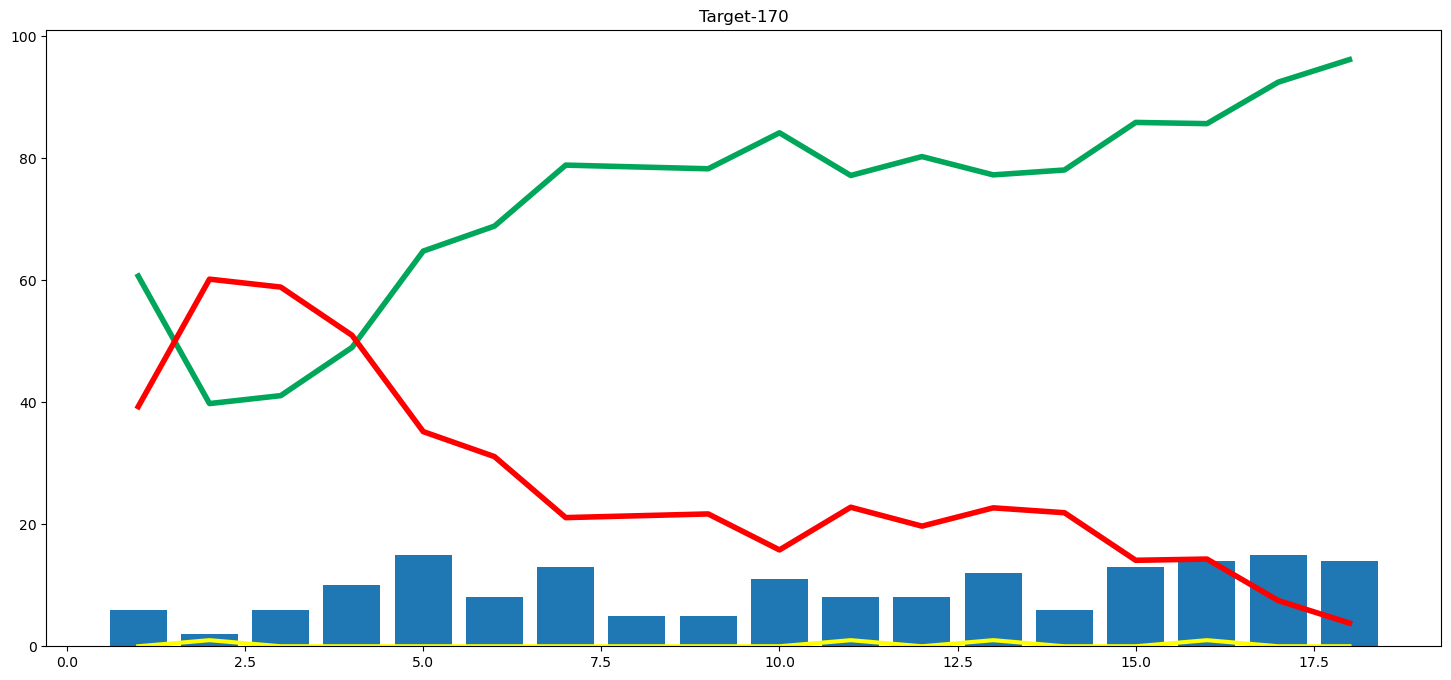

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [83]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals',
    'Gujarat Titans',
    'Lucknow Super Giants'
]

In [84]:
df['City'].unique()

array(['Ahmedabad', 'Kolkata', 'Mumbai', 'Navi Mumbai', 'Pune', 'Dubai',
       'Sharjah', 'Abu Dhabi', 'Delhi', 'Chennai', nan, 'Hyderabad',
       'Visakhapatnam', 'Bengaluru', 'Jaipur', 'Bangalore', 'Raipur',
       'Ranchi', 'Cuttack', 'Nagpur', 'Johannesburg', 'Centurion',
       'Durban', 'Bloemfontein', 'Port Elizabeth', 'Kimberley',
       'East London', 'Cape Town'], dtype=object)

In [86]:
import pickle
pickle.dump(pipe,open('pipe1.pkl','wb'))